In [14]:
#imports
import matplotlib.pyplot as plt
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [2]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

In [3]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [4]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

input_0: ──■───────
            │       
 input_1: ──┼────■──
          ┌─┴─┐┌─┴─┐
output_0: ┤ X ├┤ X ├
          └───┘└───┘

In [5]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

In [6]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

v_0: ──■─────────■────────────────────────────────
         │         │                                
  v_1: ──┼────■────┼─────────■──────────────────────
         │    │    │         │                      
  v_2: ──┼────┼────┼────■────┼─────────■────────────
         │    │    │    │    │         │            
  v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
  c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
       └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
  c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
                 └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
  c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                           └───┘└───┘┌─┴─┐┌─┴─┐  │  
  c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                     └───┘└───┘┌─┴─┐
out_0: ────────────────────────────────────────┤ X ├
                                               └───┘

In [10]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

IndexError: list index out of range

In [11]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

┌───┐               ░                                                                                       ░ ┌────────┐                                                                                      ░ ┌────────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├──■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├┤M├─────────
                      ├───┤               ░   │         │                                  │         │                            ░ │        │  │         │                                  │         │                            ░ │        │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├──────
                      ├───┤               ░   │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │  │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │  │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░            ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░───────────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────╫──╫──╫──╫─
                                          ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░                               └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░            ║  ║  ║  ║ 
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░─────────────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├

job id: e10970ed-d7bb-41c7-a2a8-958fc9a4333e
Job Status: job has successfully run


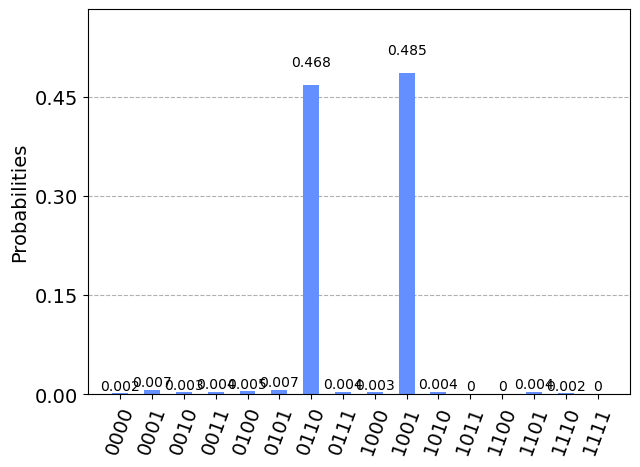

In [15]:
# Simulate and plot results
backend = Aer.get_backend('aer_simulator')
#provider = IBMQ.load_account()
#backend = provider.get_backend('ibm_oslo')

job = execute(qc, backend=backend, shots=1024)
print("job id:", job.job_id())
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts())